In [1]:
import string
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display
from timeit import default_timer as timer

## 1. Algorytm wyszukiwania wzorca 2-wymiarowego

In [2]:
def uniq_columns(pattern):
    num_rows = len(pattern)
    num_cols = len(pattern[0])
    uniq_cols = []
    indices = []
    uniq_vals = set()

    for col_idx in range(num_cols):
        column = [pattern[row_idx][col_idx] for row_idx in range(num_rows)]

        if column not in uniq_cols:
            uniq_cols.append(column)

        indices.append(uniq_cols.index(column))
        uniq_vals.update(column)

    return uniq_cols, indices, uniq_vals

In [3]:
def vertical_automaton(columns, symbols):
    num_columns = len(columns)
    num_rows = len(columns[0])
    state_list = [0] * num_columns
    transitions = [{}]
    word_list = [[]]
    
    for col_index in range(num_rows):
        for column_index in range(num_columns):
            current_symbol = columns[column_index][col_index]
            
            if current_symbol not in transitions[state_list[column_index]]:
                new_state = len(transitions)
                transitions[state_list[column_index]][current_symbol] = new_state
                word_list.append(word_list[state_list[column_index]] + [current_symbol])
                state_list[column_index] = new_state
                transitions.append({})
            else:
                state_list[column_index] = transitions[state_list[column_index]][current_symbol]
    
    n_transitions = len(transitions)
    for state_index in range(n_transitions):
        for symbol in symbols:
            if symbol in transitions[state_index]:
                continue
                
            current_state = 0    
            suffix = (word_list[state_index] + [symbol])[1:]
            for i in range(len(suffix)):
                s = suffix[i]
                if s in transitions[current_state]:
                    current_state = transitions[current_state][s]
                else:
                    current_state = 0
            
            transitions[state_index][symbol] = current_state
                               
    return transitions, state_list

In [4]:
def horizontal_automaton(pattern, letters):
    n = len(pattern)
    automaton = []

    for state in range(n + 1):
        automaton.append({})
        for letter in letters:
            if state + 1 <= n:
                new_state = state + 1
            else:
                new_state = n
                
            found_match = False
            while not found_match:
                pattern_prefix = pattern[:new_state]
                pattern_suffix = (pattern[:state] + [letter])[state - new_state + 1:state + 1]

                if pattern_prefix == pattern_suffix:
                    found_match = True
                else:
                    new_state -= 1
            
            if found_match:
                automaton[state][letter] = new_state
            else:
                automaton[state][letter] = 0

    return automaton

In [5]:
def match_2d(text, pattern):
    pattern_columns, pattern_indices, pattern_letters = uniq_columns(pattern)

    vertical_trans_table, vertical_states = vertical_automaton(pattern_columns, pattern_letters)

    pattern_list = []
    for i in range(len(pattern_indices)):
        pattern_list.append(vertical_states[pattern_indices[i]])

    horizontal_trans_table = horizontal_automaton(pattern_list, vertical_states)
    horizontal_trans_table_length = len(horizontal_trans_table) - 1

    matches = []
    current_vertical_states = []

    for row in range(len(text)):
        line = text[row]
        line_length = len(line)
        current_vertical_states_length = len(current_vertical_states)

        if line_length < current_vertical_states_length:
            current_vertical_states = current_vertical_states[:line_length]
        elif current_vertical_states_length < line_length:
            zeros_list = [0]*(line_length - current_vertical_states_length)
            current_vertical_states.extend(zeros_list)

        current_horizontal_state = 0

        for col in range(len(line)):
            letter = line[col]
            current_vertical_state = current_vertical_states[col]
            if letter in vertical_trans_table[current_vertical_state]:
                current_vertical_state = vertical_trans_table[current_vertical_state][letter]
            else:
                current_vertical_state = 0
                
            current_vertical_states[col] = current_vertical_state
            current_horizontal_states = horizontal_trans_table[current_horizontal_state]
            if current_vertical_state not in current_horizontal_states:
                current_horizontal_state = 0
            else:
                current_horizontal_state = current_horizontal_states[current_vertical_state]
                if current_horizontal_state == horizontal_trans_table_length:
                    matches.append([row - len(pattern) + 1, col - len(pattern[0]) + 1])

    return matches

## 2. Znajdowanie pozycji w pliku `haystack.txt`, na których taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach

In [6]:
with open("haystack.txt", encoding="utf-8") as f:
        text = f.readlines()

In [7]:
text

['One of the simplest and n a t u r a l types of information representation is by means\n',
 'of written texts. This type of d a t a is characterized by t h e fact t h a t it can\n',
 'be written down as a long sequence of characters. Such linear a sequence\n',
 'is called a text. T h e texts are central in "word processing" systems, which\n',
 'provide facilities for t h e manipulation of texts. Such systems usually process\n',
 'objects t h a t are quite large. For example, this book probably contains more\n',
 't h a n a million characters. Text algorithms occur in many areas of science and\n',
 'information processing. Many text editors and programming languages have\n',
 'facilities for processing texts. In biology, text algorithms arise in the study\n',
 'of molecular sequences. T h e complexity of text algorithms is also one of t h e\n',
 'central and most studied problems in theoretical computer science. It could\n',
 'be said t h a t it is the domain in which practice and theo

In [8]:
def get_2d_match(text):
    alphabet = string.ascii_lowercase
    result = []
    
    for letter in alphabet:
        indices = match_2d(text, [letter, letter])
        for i in range(len(indices)):
            indices[i].append(letter)
        result.extend(indices)
    result.sort()
    
    for line, col, letter in result:
        print(f"Znaleziono literę '{letter}' w wierszu {str(line).ljust(3)} i  {str(line+1).ljust(3)}, kolumnie {str(col).ljust(3)}")

In [9]:
get_2d_match(text)

Znaleziono literę 't' w wierszu 0   i  1  , kolumnie 7  
Znaleziono literę 'e' w wierszu 0   i  1  , kolumnie 63 
Znaleziono literę 'a' w wierszu 0   i  1  , kolumnie 82 
Znaleziono literę 'n' w wierszu 0   i  1  , kolumnie 83 
Znaleziono literę 'w' w wierszu 1   i  2  , kolumnie 3  
Znaleziono literę 'r' w wierszu 1   i  2  , kolumnie 4  
Znaleziono literę 'i' w wierszu 1   i  2  , kolumnie 5  
Znaleziono literę 't' w wierszu 1   i  2  , kolumnie 6  
Znaleziono literę 't' w wierszu 1   i  2  , kolumnie 7  
Znaleziono literę 'e' w wierszu 1   i  2  , kolumnie 8  
Znaleziono literę 'n' w wierszu 1   i  2  , kolumnie 9  
Znaleziono literę 'a' w wierszu 3   i  4  , kolumnie 30 
Znaleziono literę 't' w wierszu 3   i  4  , kolumnie 37 
Znaleziono literę 'c' w wierszu 3   i  4  , kolumnie 54 
Znaleziono literę 's' w wierszu 3   i  4  , kolumnie 57 
Znaleziono literę 's' w wierszu 3   i  4  , kolumnie 63 
Znaleziono literę 't' w wierszu 4   i  5  , kolumnie 14 
Znaleziono literę 't' w wierszu

## 3. Znajdowanie wszystkich wystąpień "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji

In [10]:
def get_th_results(text):
    th_list = [["th", "th"], ["t h", "t h"]]
    
    for th in th_list:
        result = match_2d(text, th)
        if not result:
            print(f"Nie znaleziono wystąpień '{th[0]}' w dwóch kolejnych liniach na tej samej pozycji")
            continue
            
        for line, col in result:
            print(f"Znaleziono '{th[0]}' w wierszu {str(line).ljust(3)} i  {str(line+1).ljust(3)}, kolumnie {str(col).ljust(3)}")

In [11]:
get_th_results(text)

Nie znaleziono wystąpień 'th' w dwóch kolejnych liniach na tej samej pozycji
Znaleziono 't h' w wierszu 37  i  38 , kolumnie 0  


## 4. Znajdowanie wszystkich wystąpień dowolnych 4 małych liter w pliku `haystack.png` 

In [12]:
def png2mat(png_file):
    image = Image.open(png_file)
    width, height = image.size
    
    matrix = []
    for y in range(height):
        row = []
        for x in range(width):
            pixel = image.getpixel((x, y))
            row.append(pixel[0])
        matrix.append(row)
        
    return matrix

In [13]:
text_mat = png2mat("pictures/haystack.png")
letters = {}
letters["t"] = png2mat("pictures/letter_t.png")
letters["i"] = png2mat("pictures/letter_i.png")
letters["x"] = png2mat("pictures/letter_x.png")
letters["y"] = png2mat("pictures/letter_y.png")

In [14]:
def show_pattern(pattern):
    column_widths = [max(map(len, map(str, col))) for col in zip(*pattern)]

    for row in pattern:
        formatted_row = [str(element).ljust(width) for element, width in zip(row, column_widths)]
        print(" ".join(formatted_row))

**W macierzach powstałych z przekonwertowania zdjęć liter w formacie png można zauważyć ich kształt, który odpowiada mniejszym wartościom w macierzy. Oczywiście ilość elementów w macierzy zależy od ilości pikseli w załączonym zdjęciu. Poniżej podgląd macierzy:**

--------------------------------------------------
Litera 't':
255 171 0   179 255 255 255
255 171 0   179 255 255 255
255 171 0   179 255 255 255
123 0   0   0   0   0   95 
123 0   0   0   0   0   95 
255 171 0   179 255 255 255
255 171 0   179 255 255 255
255 171 0   179 255 255 255
255 171 0   179 255 255 255
255 173 0   176 255 255 255
255 190 0   108 245 255 255
255 241 9   0   0   0   95 
255 255 176 46  6   0   95 


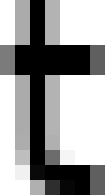

--------------------------------------------------
Litera 'i':
179 0   175
179 0   175
255 255 255
255 255 255
179 0   175
179 0   175
179 0   175
179 0   175
179 0   175
179 0   175
179 0   175
179 0   175
179 0   175
179 0   175


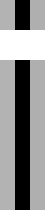

--------------------------------------------------
Litera 'x':
58  11  215 255 255 255 153 0   126
224 16  47  247 255 212 9   61  252
255 173 0   107 246 44  18  226 255
255 255 105 0   58  0   176 255 255
255 255 247 35  0   104 255 255 255
255 255 201 5   0   60  252 255 255
255 241 33  25  133 0   125 255 255
255 88  2   189 255 85  2   192 255
156 0   122 255 255 239 31  27  236
10  58  251 255 255 255 198 4   78 


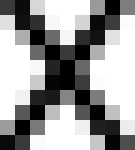

--------------------------------------------------
Litera 'y':
187 0   142 255 255 255 255 255 52  28 
254 37  41  255 255 255 255 208 0   129
255 141 0   196 255 255 255 107 4   229
255 237 8   96  255 255 246 16  82  255
255 255 94  10  240 255 162 0   187 255
255 255 199 0   150 255 61  37  254 255
255 255 255 48  50  216 0   140 255 255
255 255 255 153 0   69  8   236 255 255
255 255 255 244 14  0   94  255 255 255
255 255 255 255 100 0   198 255 255 255
255 255 255 255 53  45  255 255 255 255
255 255 250 143 0   139 255 255 255 255
255 107 0   0   15  237 255 255 255 255
255 107 1   39  187 255 255 255 255 255


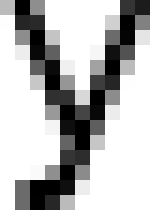

In [15]:
for letter, letter_mat in letters.items():
    print("-"*50)
    print(f"Litera '{letter}':")
    show_pattern(letter_mat)
    image = Image.open(f"pictures/letter_{letter}.png")
    new_size = (image.width*15, image.height*15)
    image = image.resize(new_size, resample=Image.NEAREST)
    display(image)

**Ilość wystąpień wybranych liter w tekście wyszukanych za pomocą algorytmu na podstawie załączonych zdjęć png**

**vs**

**Rzeczywista ilość wystąpień wybranych liter w tekście**

In [16]:
def check_pattern_occurrences(text, pattern):
    cnt = 0
    for line in text:
        cnt += line.count(pattern)
        
    return cnt

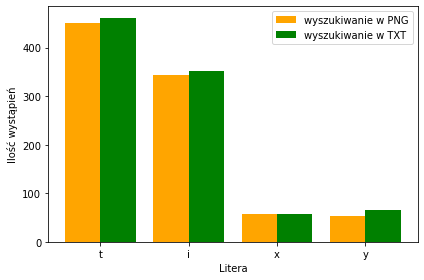

In [17]:
counts_txt = []
counts_png = []

for letter, letter_mat in letters.items():
    counts_png.append(len(match_2d(text_mat, letter_mat)))
    counts_txt.append(check_pattern_occurrences(text, letter))
  
x = np.arange(len(counts_txt))
width = 0.4
plt.bar(x-0.2, counts_png, width, color="orange")
plt.bar(x+0.2, counts_txt, width, color="green")
plt.xticks(x, letters.keys())
plt.xlabel("Litera")
plt.ylabel("Ilość wystąpień")
plt.legend(["wyszukiwanie w PNG", "wyszukiwanie w TXT"])
plt.tight_layout()
plt.show()

## 5. Znajdowanie wszystkich wystąpień słowa "p a t t e r n" w pliku `haystack.png`

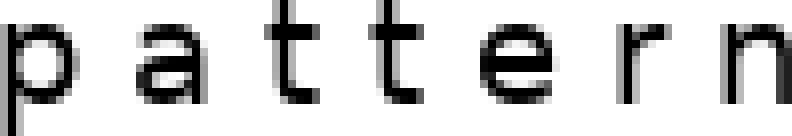

In [18]:
pattern_mat = png2mat("pictures/pattern.png")
image = Image.open("pictures/pattern.png")
normal_width, normal_height = image.width, image.height
new_size = (normal_width*8, normal_height*8)
image = image.resize(new_size, resample=Image.NEAREST)
display(image)

**Wyszukiwanie w TXT**

In [19]:
check_pattern_occurrences(text, "p a t t e r n")

5

**Wyszukiwanie w PNG**

In [20]:
pattern_results = match_2d(text_mat, pattern_mat)
len(pattern_results), pattern_results

(5, [[474, 184], [496, 428], [540, 242], [584, 142], [628, 248]])

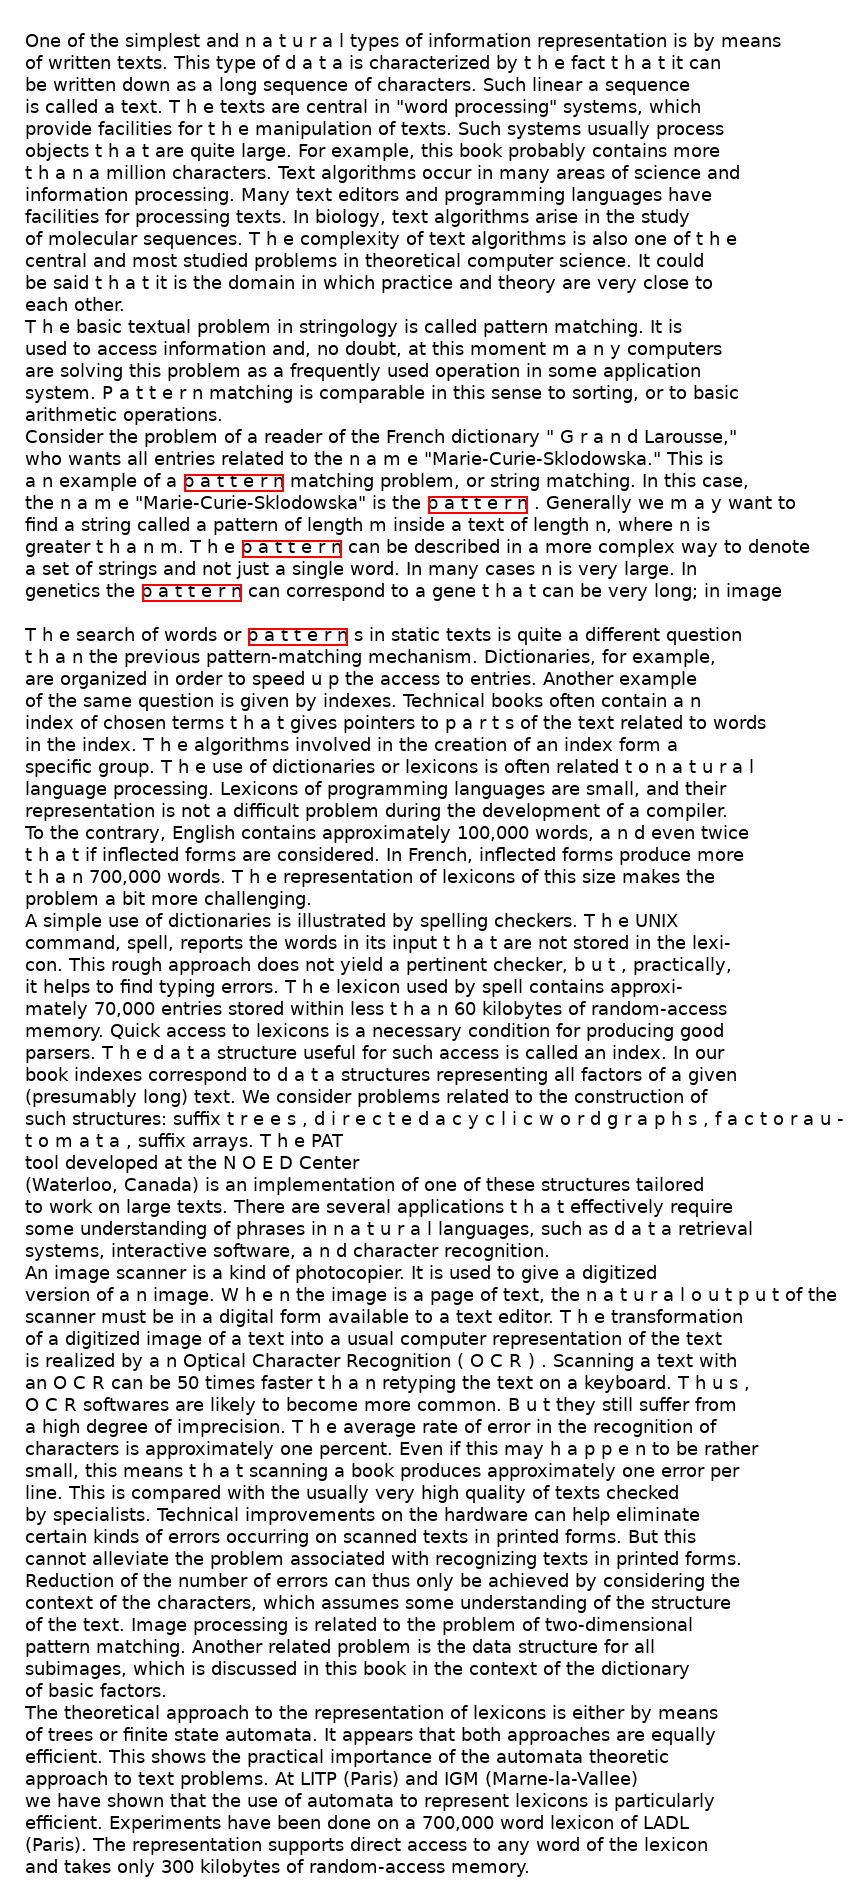

In [21]:
image = Image.open("pictures/haystack.png")
draw = ImageDraw.Draw(image)

for y, x in pattern_results:
    draw.rectangle([(x, y), (x+normal_width, y+normal_height)], outline="red", width=2)

display(image)

## 6. Porównanie czasów budowania automatu i czasów wyszukiwania dla różnych rozmiarów wzorca 

In [22]:
def get_times(text, pattern):
    start = timer()
    pattern_columns, pattern_indices, pattern_letters = uniq_columns(pattern)
    vertical_trans_table, vertical_states = vertical_automaton(pattern_columns, pattern_letters)
    pattern_list = []
    
    for i in range(len(pattern_indices)):
        pattern_list.append(vertical_states[pattern_indices[i]])
    horizontal_trans_table = horizontal_automaton(pattern_list, vertical_states)
    horizontal_trans_table_length = len(horizontal_trans_table) - 1
    end = timer()
    time_build = end - start
    
    
    start = timer()
    matches = []
    current_vertical_states = []
    for row in range(len(text)):
        line = text[row]
        line_length = len(line)
        current_vertical_states_length = len(current_vertical_states)
        if line_length < current_vertical_states_length:
            current_vertical_states = current_vertical_states[:line_length]
        elif current_vertical_states_length < line_length:
            zeros_list = [0]*(line_length - current_vertical_states_length)
            current_vertical_states.extend(zeros_list)

        current_horizontal_state = 0

        for col in range(len(line)):
            letter = line[col]
            current_vertical_state = current_vertical_states[col]
            if letter in vertical_trans_table[current_vertical_state]:
                current_vertical_state = vertical_trans_table[current_vertical_state][letter]
            else:
                current_vertical_state = 0
                
            current_vertical_states[col] = current_vertical_state
            current_horizontal_states = horizontal_trans_table[current_horizontal_state]
            if current_vertical_state not in current_horizontal_states:
                current_horizontal_state = 0
            else:
                current_horizontal_state = current_horizontal_states[current_vertical_state]
                if current_horizontal_state == horizontal_trans_table_length:
                    matches.append([row - len(pattern) + 1, col - len(pattern[0]) + 1])
    end = timer()
    time_search = end - start
    
    return time_build, time_search

In [23]:
def time_test():
    pattern_len = [1]
    pattern_len.extend(list(range(10, 101, 10)))
    n_lines = len(text)
    build_times = []
    search_times = []
    
    for size in pattern_len:
        while True:
            i = random.randint(0, n_lines-1)
            if len(text[i]) > size:
                pattern = text[i][:size]
                break
        time_build, time_search = get_times(text, pattern)
        build_times.append(time_build)
        search_times.append(time_search)
        
    return pattern_len, build_times, search_times

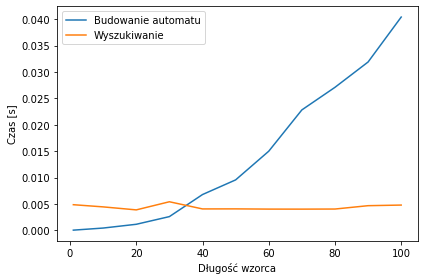

In [24]:
pattern_len, build_times, search_times = time_test()

plt.plot(pattern_len, build_times, label="Budowanie automatu")
plt.plot(pattern_len, search_times, label="Wyszukiwanie")
plt.xlabel("Długość wzorca")
plt.ylabel("Czas [s]")
plt.tight_layout()
plt.legend()

## 7. Czasy przeszukiwania w podzielonym poziomo na 2, 4, i 8 fragmenty pliku

In [25]:
num_patterns = [10, 20, 30]
num_parts = [2, 4, 8]
pattern_lines = []
total_times = {}

for n_patt in num_patterns:
    times = []
    for line in text_mat[:n_patt]:
        pattern_lines.append(line[:n_patt])
    
    for num_part in num_parts:
        n = len(text_mat) // num_part
        text_ranges = []

        for i in range(num_part):
            text_ranges.append(text_mat[n*i : n*(i+1)])

        start = timer()
        for i in range(num_part):
            current_text = text_ranges[i]
            match_2d(current_text, pattern_lines)
        end = timer()
        times.append(end - start)
        
    total_times[n_patt] = times

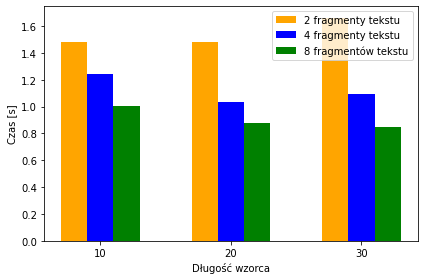

In [26]:
x = np.arange(len(num_patterns))
width = 0.2
plt.bar(x-0.2, total_times[num_patterns[0]], width, color="orange")
plt.bar(x, total_times[num_patterns[1]], width, color="blue")
plt.bar(x+0.2, total_times[num_patterns[2]], width, color="green")
plt.xticks(x, total_times.keys())
plt.xlabel("Długość wzorca")
plt.ylabel("Czas [s]")
plt.legend(["2 fragmenty tekstu", "4 fragmenty tekstu", "8 fragmentów tekstu"])
plt.tight_layout()
plt.show()